In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from nltk.tokenize.regexp import WhitespaceTokenizer
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [2]:
top5CollsTrip = ["barcelona", "dublin", "amsterdam", "athens", "berlin"]
top5CollsTrip = [i+"Tripadvisor" for i in top5CollsTrip]
top5CollsBooking = ["edinburgh", "dublin", "manchester", "barcelona", "berlin"]
top5CollsBooking = [i+"Booking" for i in top5CollsBooking]

In [3]:
# connect to the db
client = MongoClient()
db = client.sentimentAnalysis

In [4]:
def getCollection(collName = ""):
    '''
    return pandas dataframe.
    '''
    cursor = db[collName].find({})
    df = pd.DataFrame(list(cursor))
    return df

In [5]:
# BarcelonaTripDF = getCollection(top5CollsTrip[0])

In [6]:
def convertDate(stringDate):
    '''
    convert string date format into python comparable striptime format
    '''
    return dt.strptime(stringDate, "%B %d, %Y")



def calculateStatistics(collDF):
    '''
    input parameter is dataframe of one specific collection
    return includes three different variables
    '''
    # calculate the number of words in each reviews data and then add it as a new column
    reviewsLen = list()
    bagWords = list()
    def calculateWordCount(review = ""):
        tokens = WhitespaceTokenizer().tokenize(review)
        reviewLen = len(tokens)
        reviewsLen.append(reviewLen)
        bagWords.append(tokens)

    for i in collDF["review"]:
#         print(i)
        calculateWordCount(i)
    collDF["wordCount"] = pd.Series(reviewsLen, index=collDF.index)
    collDF = collDF.astype(dtype={"hotelStars": float}, copy=False)
    
    
    
        # group Barcelona collection review data by hotel, and then get basic statistics for each hotel.
    hotelsStatList = list()
    for hotelurl, group in collDF.groupby("hotelName"):
    #     print(hotelurl)
        reviewNum = len(group)
        reviewsDateList = group["date"].apply(convertDate)
        earliestDate = min(reviewsDateList)
        latestDate = max(reviewsDateList)
        hotelsStat = [hotelurl, reviewNum, earliestDate, latestDate]
        hotelsStatList.append(hotelsStat)
    hotelsStatDF = pd.DataFrame(hotelsStatList, columns=["hotelName", "reviewCount", "earliestDate", "latestDate"])
    
#     this variable returns hotels in that cities statistics
    hotelsStatDF = hotelsStatDF.sort_values(by="reviewCount", ascending=False)
    
    return hotelsStatDF, collDF, bagWords

In [7]:
def drawBoxplot(reviewsDF):
    flt1 = plt.figure()
    ax1 = flt1.add_subplot(111)
    ax1.set_ylabel("hotels category stars")
    ax1.set_title("Barcelona Tripadvisor.com")
    ax1.boxplot(BarcelonaTripDF["hotelStars"])
    flt1.show()
    plt.show()
    
    flt2 = plt.figure()
    ax2 = flt2.add_subplot(111)
    ax2.set_ylabel("review grades")
    ax2.set_title("Barcelona Tripadvisor.com")
    ax2.boxplot(BarcelonaTripDF["score"])
    flt2.show()
    plt.show()
    
    flt3 = plt.figure()
    ax3 = flt3.add_subplot(111)
    ax3.set_ylabel("review word count")
    ax3.set_title("Barcelona Tripadvisor.com")
    ax3.boxplot(BarcelonaTripDF["wordCount"])
    flt3.show()
    plt.show()

In [8]:
# hotelsStatDF, collDF, bagWords = calculateStatistics(BarcelonaTripDF)

In [9]:
# scoresPercentile = collDF["score"].value_counts(normalize=True) * 100

In [10]:
# DublinTripDF = getCollection(top5CollsTrip[1])
# AmsterdamTripDF = getCollection(top5CollsTrip[2])
# AthensTripDF = getCollection(top5CollsTrip[3])
# BerlinTripDF = getCollection(top5CollsTrip[4])

In [11]:
scoresPercent = list()
allCitiesCollDF = list()
allBagWords = list()
def calculateEachCity(cityName):
    hotelsStatDF, collDF, bagWords = calculateStatistics(getCollection(cityName))
    scoresPercentThisCity = collDF["score"].value_counts(normalize=True).values * 100
    scoresPercent.append(scoresPercentThisCity)
    allCitiesCollDF.append(collDF)
    allBagWords.append(bagWords)

In [12]:
for i in top5CollsTrip:
    calculateEachCity(i)

In [13]:
type(scoresPercent)

list

In [14]:
scoresPercent

[array([ 54.4921875 ,  26.33463542,  11.03515625,   4.45963542,   3.67838542]),
 array([ 49.75352113,  28.52112676,  12.14788732,   5.63380282,   3.94366197]),
 array([ 53.8585209 ,  29.26045016,   9.96784566,   3.49678457,   3.41639871]),
 array([ 49.5008808 ,  31.35642983,  11.39166177,   4.05167352,   3.69935408]),
 array([ 44.20828905,  32.73113709,  13.07120085,   6.48246546,   3.50690755])]

In [15]:
scoresPercent = np.array(scoresPercent).T.tolist()

In [16]:
scoresPercent

[[54.4921875,
  49.75352112676056,
  53.85852090032154,
  49.50088079859072,
  44.208289054197664],
 [26.334635416666668,
  28.52112676056338,
  29.260450160771708,
  31.356429829712273,
  32.731137088204036],
 [11.03515625,
  12.147887323943662,
  9.967845659163988,
  11.391661773341163,
  13.071200850159407],
 [4.459635416666666,
  5.633802816901409,
  3.4967845659163985,
  4.051673517322373,
  6.482465462274177],
 [3.6783854166666665,
  3.943661971830986,
  3.4163987138263665,
  3.69935408103347,
  3.5069075451647183]]

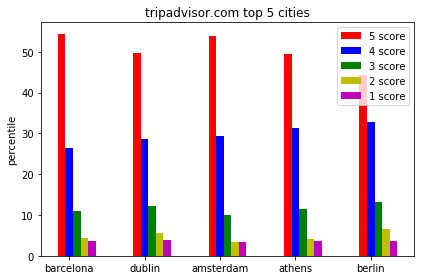

In [18]:
# draw the bar score distribution on these five cities
N = 5
ind = np.arange(N)
width = 0.1
barWidth = 0.1

ax = plt.subplot(111)
colors = ["r", "b", "g", "y", "m"]

rects0 = ax.bar(ind, list(scoresPercent[0]), barWidth, color=colors[0])
rects1 = plt.bar(ind+width, list(scoresPercent[1]), barWidth, color=colors[1])
rects2 = plt.bar(ind+width*2, list(scoresPercent[2]), barWidth, color=colors[2])
rects3 = plt.bar(ind+width*3, list(scoresPercent[3]), barWidth, color=colors[3])
rects4 = plt.bar(ind+width*4, list(scoresPercent[4]), barWidth, color=colors[4])
ax.set_ylabel("percentile")
ax.set_xticks(ind+width)
ax.set_xticklabels(("barcelona", "dublin", "amsterdam", "athens", "berlin"))
ax.legend((rects0[0], rects1[0], rects2[0], rects3[0], rects4[0]), 
            ('5 score', '4 score', '3 score', '2 score', '1 score', '0 score'))
plt.title("tripadvisor.com top 5 cities")

plt.tight_layout()
plt.show()

In [35]:
# for 5 stars reviws, extract its keywords, for other stars, extract its keywords as well.
# keyword extraction algorithm
reviewsDict = dict()
# 5-stars reviews
for eachColl in allCitiesCollDF:
    for score, group in eachColl.groupby(["score"]):
        if str(score) not in reviewsDict.keys():
            reviewsDict[str(score)] = list()
            reviewsDict[str(score)].append(group["review"])
        else:
            reviewsDict[str(score)].append(group["review"])  
    

# 4-stars reviewsb

In [36]:
# the cities order is: "barcelona", "dublin", "amsterdam", "athens", "berlin"
len(reviewsDict["1.0"])

5

In [39]:
# we take barcelona as example
star1Num = len(list(reviewsDict["1.0"][0]))
star2Num = len(list(reviewsDict["2.0"][0]))
star3Num = len(list(reviewsDict["3.0"][0]))
star4Num = len(list(reviewsDict["4.0"][0]))
star5Num = len(list(reviewsDict["5.0"][0]))
print("1 star, 2 star, 3 star, 4star, 5star", (star1Num, star2Num, star3Num, star4Num, star5Num))

1 star, 2 star, 3 star, 4star, 5star (113, 137, 339, 809, 1674)


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [57]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


from time import time
from sklearn.decomposition import NMF, LatentDirichletAllocation
def calculate_topicModel(textData):
    n_samples = len(textData)
    n_features = 1000
    n_components = 1
    n_top_words = 5
    
    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(textData)
    print("tfidf data type: ", type(tfidf))
    print("done in %0.3fs." % (time() - t0))
    
    # Fit the NMF model
    print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
          "n_samples=%d and n_features=%d..."
          % (n_samples, n_features))
    t0 = time()
    nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
    
    print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)
    

In [51]:
calculate_topicModel(list(reviewsDict["1.0"][0]))

Extracting tf-idf features for NMF...
tfidf data type:  <class 'scipy.sparse.csr.csr_matrix'>
done in 0.028s.
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=113 and n_features=1000...

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: room hotel rooms stay staff
Topic #1: sun hear morning place people
Topic #2: icepack medicine asked brout unfrozened



In [58]:
# rerun again with setting n_component = 1
calculate_topicModel(list(reviewsDict["1.0"][0]))

Extracting tf-idf features for NMF...
tfidf data type:  <class 'scipy.sparse.csr.csr_matrix'>
done in 0.039s.
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=113 and n_features=1000...

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: room hotel rooms staff stay



In [52]:
calculate_topicModel(list(reviewsDict["1.0"][1]))

Extracting tf-idf features for NMF...
tfidf data type:  <class 'scipy.sparse.csr.csr_matrix'>
done in 0.023s.
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=112 and n_features=1000...

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: hotel room night sleep staff
Topic #1: fee account weeks stayed fine
Topic #2: coffee better service bar ups



In [53]:
calculate_topicModel(list(reviewsDict["1.0"][2]))

Extracting tf-idf features for NMF...
tfidf data type:  <class 'scipy.sparse.csr.csr_matrix'>
done in 0.024s.
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=87 and n_features=1000...

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: room hotel night rooms stay
Topic #1: card credit did reservation hotel
Topic #2: service bath cleaning poor people



In [55]:
calculate_topicModel(list(reviewsDict["5.0"][0]))

Extracting tf-idf features for NMF...
tfidf data type:  <class 'scipy.sparse.csr.csr_matrix'>
done in 2.920s.
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=1674 and n_features=1000...

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: great location really recommend highly
Topic #1: good metro close nice clean
Topic #2: hotel room barcelona staff stay



In [29]:
len(reviewsDict["1.0"][0])

112

In [32]:
list(reviewsDict["1.0"][0])

['Boy did we learn the hard way!! Do your research before booking!! The only redeeming feature of this hotel is the location close to the city. If I could grade this hotel with a "0.5" or even a "0" I would. This is a 2 star hotel with a popular nightclub on site. Warned about noise after check in. Even found the hotel provided ear plugs - which didn\'t work !! We were provided with twin beds in a claustrophobic hotbox! One small window which had to be closed at night to minimise the noise from the nightclub. The ensuite was small and had a broken toilet lid and seat. In the room there was outdated information regarding meals. In reality we found - Breakfast available everyday. Lunch only Mon - Friday. No evening meals for guests on weekends. Bar on a Saturday not open until 11.00pm for the nightclub. No room service. No obvious facilities for the disabled.The nightclub proved to be a nightmare for us with the amount of noise generated and also the noise generated by the staff cleaning

In [33]:
len(list(reviewsDict["1.0"][0]))

112

In [34]:
list(reviewsDict["1.0"][0])[0]

'Boy did we learn the hard way!! Do your research before booking!! The only redeeming feature of this hotel is the location close to the city. If I could grade this hotel with a "0.5" or even a "0" I would. This is a 2 star hotel with a popular nightclub on site. Warned about noise after check in. Even found the hotel provided ear plugs - which didn\'t work !! We were provided with twin beds in a claustrophobic hotbox! One small window which had to be closed at night to minimise the noise from the nightclub. The ensuite was small and had a broken toilet lid and seat. In the room there was outdated information regarding meals. In reality we found - Breakfast available everyday. Lunch only Mon - Friday. No evening meals for guests on weekends. Bar on a Saturday not open until 11.00pm for the nightclub. No room service. No obvious facilities for the disabled.The nightclub proved to be a nightmare for us with the amount of noise generated and also the noise generated by the staff cleaning 

In [ ]:
# strong variation.

In [135]:
hotelsStatDF[:3]

,hotelName,reviewCount,earliestDate,latestDate
155,Hotel Arts Barcelona,75,2017-07-11,2017-08-09
130,Hilton Diagonal Mar Barcelona,72,2017-07-11,2017-08-12
106,Grand Hotel Central,72,2017-07-05,2017-08-12


In [133]:
BarcelonaTripDF[:3]

,_id,date,hotelLocation,hotelName,hotelStars,hotelUrl,review,score,title,url,userId,wordCount
0,5987192c9b1f26681686008e,"July 31, 2017","Carrer Elisabets 11, 08001 Barcelona, Spain",Casa Camper Hotel Barcelona,4.0,https://www.tripadvisor.com/Hotel_Review-g1874...,It truly felt like coming home when we came th...,5.0,SO SO Happy to Be BACK!,https://www.tripadvisor.com/ShowUserReviews-g1...,Lili1012,221
1,5987192e9b1f26681686008f,"July 26, 2017","Carrer Elisabets 11, 08001 Barcelona, Spain",Casa Camper Hotel Barcelona,4.0,https://www.tripadvisor.com/Hotel_Review-g1874...,Perfect place to stay in Barcelona.. We spent ...,5.0,Perfect,https://www.tripadvisor.com/ShowUserReviews-g1...,AimamKaur,35
2,598719309b1f266816860090,"July 26, 2017","Carrer Elisabets 11, 08001 Barcelona, Spain",Casa Camper Hotel Barcelona,4.0,https://www.tripadvisor.com/Hotel_Review-g1874...,This hotel is ideally placed within reasonable...,5.0,Nothing was too much trouble,https://www.tripadvisor.com/ShowUserReviews-g1...,Tisketsmum,103


/home/yi/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


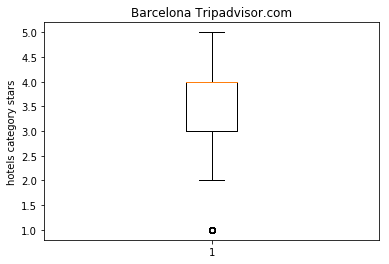

/home/yi/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


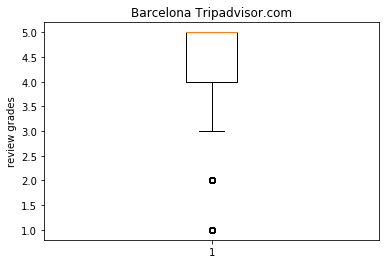

/home/yi/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


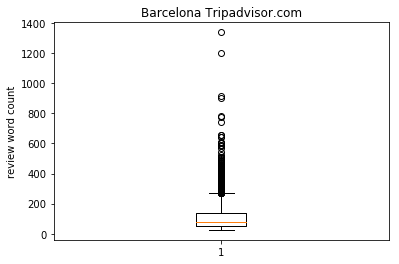

In [71]:
BarcelonaTripDF.shape

(3072, 11)

In [78]:
BarcelonaTripDF[:3]

,_id,date,hotelLocation,hotelName,hotelStars,hotelUrl,review,score,title,url,userId,wordCount
0,5987192c9b1f26681686008e,"July 31, 2017","Carrer Elisabets 11, 08001 Barcelona, Spain",Casa Camper Hotel Barcelona,4.0,https://www.tripadvisor.com/Hotel_Review-g1874...,It truly felt like coming home when we came th...,5.0,SO SO Happy to Be BACK!,https://www.tripadvisor.com/ShowUserReviews-g1...,Lili1012,221
1,5987192e9b1f26681686008f,"July 26, 2017","Carrer Elisabets 11, 08001 Barcelona, Spain",Casa Camper Hotel Barcelona,4.0,https://www.tripadvisor.com/Hotel_Review-g1874...,Perfect place to stay in Barcelona.. We spent ...,5.0,Perfect,https://www.tripadvisor.com/ShowUserReviews-g1...,AimamKaur,35
2,598719309b1f266816860090,"July 26, 2017","Carrer Elisabets 11, 08001 Barcelona, Spain",Casa Camper Hotel Barcelona,4.0,https://www.tripadvisor.com/Hotel_Review-g1874...,This hotel is ideally placed within reasonable...,5.0,Nothing was too much trouble,https://www.tripadvisor.com/ShowUserReviews-g1...,Tisketsmum,103


In [75]:
print(bagWords[0])

['It', 'truly', 'felt', 'like', 'coming', 'home', 'when', 'we', 'came', 'through', 'the', 'doors', 'of', 'Casa', 'Camper!', 'We', 'were', 'just', 'a', 'wee', 'bit', 'afraid', 'that', 'things', 'might', 'have', 'changed', 'since', 'the', 'marvelous', 'Susanna', 'Martin', 'had', 'left', 'the', 'helm', 'BUT', 'she', 'had', 'trained', 'the', 'staff', 'well', 'and', 'our', 'beloved', 'Georgina', 'was', 'there', 'to', 'welcome', 'us', 'and', 'show', 'us', 'that', 'Casa', 'Camper', 'was', 'just', 'as', 'FANTABULOUS', 'as', 'ever.', 'Having', 'been', 'in', 'the', 'air', 'FOREVER', 'with', '3', 'layovers', 'all', 'I', 'wanted', 'was', 'FOOD', 'and', 'PROTEIN', 'and', 'Georgina', 'led', 'me', 'right', 'to', 'their', 'clever', "'automat'", 'set-up', 'where', 'I', 'scarfed', 'down', 'a', 'yummy', 'sandwich', 'wrap,', 'etc.', 'Feeling', 'revived,', 'we', 'headed', 'up', 'to', 'our', 'lovely', 'room', 'and', 'then', 'out', 'the', 'door', 'to', 'get', 'our', 'first', 'glimpse', 'of', 'Las', 'Ramblas'

In [83]:
BarcelonaTripDF.dtypes

_id               object
date              object
hotelLocation     object
hotelName         object
hotelStars       float64
hotelUrl          object
review            object
score            float64
title             object
url               object
userId            object
wordCount          int64
dtype: object

In [84]:
BarcelonaTripDF.describe()

,hotelStars,score,wordCount
count,3072.000000,3072.000000,3072.000000
mean,3.795898,4.235026,112.020833
std,0.891460,1.053488,97.174382
min,1.000000,1.000000,25.000000
25%,3.000000,4.000000,49.000000
50%,4.000000,5.000000,80.000000
75%,4.000000,5.000000,138.000000
max,5.000000,5.000000,1339.000000


In [ ]:
# add another column which tags cities name and website type.

In [ ]:
# define a dataframe, columns = ["collection name", "count", "mean", "std", "min", "max", "score_1", "score_2",
# "score_3", "score_4", ]